In [1]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt

## Cargar la base de datos

In [2]:
try:
    conn = psycopg2.connect(
        host='localhost',
        user='postgres',
        password='root',
        database='arriendos',
        port='5432'
    )  # type: ignore
    print('Conexión exitosa')
    cur = conn.cursor()
    sql = '''select u.nombre, u.fecha_ingreso, u.precio_pactado, d.departamento, d.id_departamento, 
            p.mes_pago, p.year_pago, p.monto_pago, p.fecha_pago from usuarios u
            join departamentos d on d.id_usuario = u.id_usuario
            join Pagos p on u.id_usuario = p.id_usuario;'''
    cur.execute(sql)
    datos = cur.fetchall()
    columnas = [descripcion[0] for descripcion in cur.description]
    cur.close()
    conn.close()
except Exception as ex:
    print(f'Error: {ex}')
else:
    print('Cerrando sesión')

Conexión exitosa
Cerrando sesión


In [3]:
df = pd.DataFrame(datos, columns=columnas)
df.columns


Index(['nombre', 'fecha_ingreso', 'precio_pactado', 'departamento',
       'id_departamento', 'mes_pago', 'year_pago', 'monto_pago', 'fecha_pago'],
      dtype='object')

## Procesamiento datos

In [4]:
meses_numeros = {'ENE': 1, 'FEB': 2, 'MAR': 3, 'ABR': 4, 'MAY': 5, 'JUN': 6, 'JUL': 7, 'AGO': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DIC': 12}

In [5]:
# Crear una nueva columna con los números de los meses para todos los registros
df['mes_numero'] = df['mes_pago'].map(meses_numeros)

# Crea un dataframe para ver el nombre de los usuarios y sus pagos segun los meses
pivot_df = df.pivot_table(index=['nombre', 'departamento'], columns='mes_numero', values=['monto_pago', 'fecha_pago'], aggfunc={'monto_pago': 'sum', 'fecha_pago': 'first'})
pivot_df.columns = pivot_df.columns.swaplevel()
pivot_df = pivot_df.sort_index(axis=1)

# Cambia los numeros por el mes
iniciales_meses = list(map(lambda x: (next(key for key, value in meses_numeros.items() if value == x[0]), x[1]), pivot_df.columns))
iniciales_meses = list(map(lambda x: (x[0],x[1].replace('fecha_pago', 'fecha')), iniciales_meses))
iniciales_meses = list(map(lambda x: (x[0],x[1].replace('monto_pago', 'pago')), iniciales_meses))
pivot_df.columns = pd.MultiIndex.from_tuples(iniciales_meses)
pivot_df

ENE                 FEB          \
                                           fecha    pago       fecha    pago   
nombre              departamento                                               
Anita Chicaiza      QUITO MEDIA AGUA  2024-01-10  140.00  2024-02-14  140.00   
Emma Simbaña        AMBATO DEP2       2024-01-08  220.00  2024-02-07  220.00   
Fernando Pichucho   AMBATO DEP1       2024-01-22   90.00  2024-03-15  230.00   
Jeremy mestanza     AMBATO LOCAL IME  2024-01-23  200.00  2024-02-26  200.00   
Martha Lucia Barona QUITO CASA        2024-02-19  180.00  2024-02-26  200.00   
Nestor Castro       LAGO AGRIO CASA   2024-02-29  200.00  2024-02-29  200.00   

                                             MAR                 ABR          
                                           fecha    pago       fecha    pago  
nombre              departamento                                              
Anita Chicaiza      QUITO MEDIA AGUA  2024-03-11  140.00  2024-04-07  140.00  
Emma Simbaña        AMBATO DEP2       2024-03-08  220.00  2024-04-08  220.00  
Fernando Pichucho   AMBATO DEP1       2024-03-30  230.00         NaN     NaN  
Jeremy mestanza     AMBATO LOCAL IME  2024-03-28  200.00         NaN     NaN  
Martha Lucia Barona QUITO CASA        2024-03-15  200.00  2024-04-06  120.00  
Nestor Castro       LAGO AGRIO CASA          NaN     NaN         NaN     NaN

In [6]:
#ivot_df.iloc[:,pivot_df.columns.get_level_values(1) == 'fecha']


In [7]:
def deuda(mes='total'):
    pd.options.mode.copy_on_write = True
    if mes == 'total':
        df_meses = df.copy()
        meses = len(df_meses['mes_pago'].unique())
        df_meses['monto_pago'] = df_meses.loc[:, 'monto_pago'].astype(float)
        df_meses['precio_pactado'] = df_meses['precio_pactado'].astype(float)
        df_meses = df_meses.pivot_table(index = 'nombre', values = ['monto_pago','precio_pactado'], aggfunc={'precio_pactado': 'first', 'monto_pago':'sum'})
        df_meses['precio_pactado'] = df_meses['precio_pactado'].transform(lambda x: x*meses)
        df_meses['deuda'] = df_meses['precio_pactado'] - df_meses['monto_pago']
        return df_meses
    
    df_meses = df[df['mes_pago']== mes]
    df_meses['monto_pago'] = df_meses.loc[:, 'monto_pago'].astype(float)
    df_meses['precio_pactado'] = df_meses['precio_pactado'].astype(float)
    df_meses = df_meses.pivot_table(index = 'nombre', values = ['monto_pago','precio_pactado'], aggfunc={'precio_pactado': 'first', 'monto_pago':'sum'})
    df_meses['deuda'] = df_meses['precio_pactado'] - df_meses['monto_pago']
    return df_meses


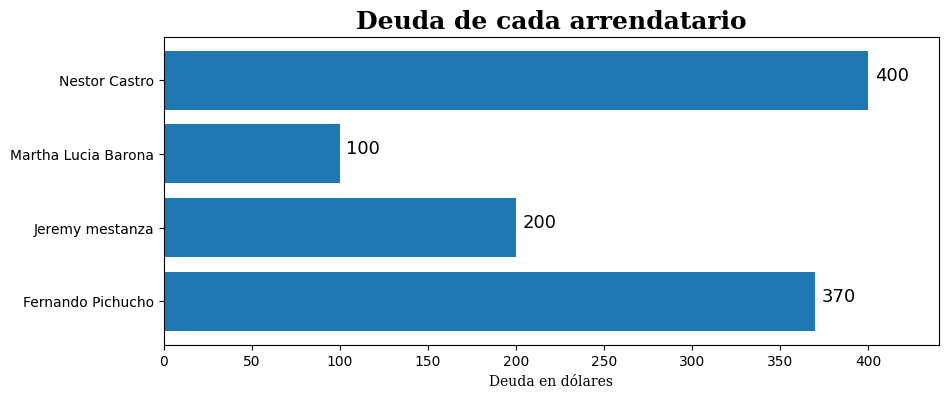

In [69]:
df_meses = deuda()
df_meses = df_meses[df_meses['deuda'] != 0]
ancho_maximo = max(df_meses['deuda'])
plt.figure(figsize=(10,4))
bars =plt.barh(df_meses.index,df_meses['deuda'], height=0.8)
plt.title('Deuda de cada arrendatario',fontsize=18, fontfamily='serif',  fontweight='bold')
plt.xlabel('Deuda en dólares',fontsize=10, fontfamily='serif')
for bar in bars:
    ancho = bar.get_width()
    plt.text(ancho+(ancho_maximo/30), bar.get_y()+bar.get_height() / 2, int(round(ancho, 1)), ha = 'center', fontsize = 13)
plt.xlim(0,ancho_maximo + (ancho_maximo/10))
plt.show()

    
    

In [10]:
df_meses = deuda()
df_meses.index

Index(['Anita Chicaiza', 'Emma Simbaña', 'Fernando Pichucho',
       'Jeremy mestanza', 'Martha Lucia Barona', 'Nestor Castro'],
      dtype='object', name='nombre')